# 1. Preprocessing for JustDance Video
In this part we do pose estimation to a video from YOUTUBE and convert it to json files. (through using OpenPose: https://github.com/CMU-Perceptual-Computing-Lab/openpose)

## 1.1 Install OpenPose

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt 
from posixpath import join
import pandas as pd
import os, sys
from google.colab import drive

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

## 1.2 Download video from YouTube

In [3]:
pip install pytube

     |████████████████████████████████| 56 kB 2.2 MB/s 


In [ ]:
from pytube import YouTube

# ask for the link from user
# We use https://www.youtube.com/watch?v=YteMhrQvfCo&t=114s
link = input("Enter the link of YouTube video you want to download:  ")
yt = YouTube(link)

#Showing details
print("Title: ",yt.title)
print("Number of views: ",yt.views)
print("Length of video: ",yt.length)
print("Rating of video: ",yt.rating)
#Getting the highest resolution possible
ys = yt.streams.get_highest_resolution()

#Starting download
print("Downloading...")
ys.download()
print("Download completed!!")

## 1.3 Sample the Video

In this part we sample the video to 1 frame per second

In [ ]:
import cv2
def collectframes(spf, vid, path): 
  '''This function is used to get frmame images from video

  ------
  param:
  ------
    spf: int
      seconds per frame
    vid: str
      video path
    path: str
      path to save result images
  
  '''
  cap = cv2.VideoCapture(vid)

  print(cap)
  # fps = cap.get(cv2.CAP_PROP_FPS)
  fps = cap.get(cv2.CAP_PROP_FPS)
  cap = cap.set(cv2.CAP_PROP_FPS, 30)
  print(fps)
  i=0
  while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
      print("Done")
      break
        
    if i % (fps*spf) == 0:
        cv2.imwrite(path+str(i)+'.jpg',frame)
        print("Frame")
    i+=1

  cap.release()
  cv2.destroyAllWindows()

collectframes(spf=1,vid="justdance_happy_short.mp4", path = 'sampled2/')

## 1.4 Run Openpose and detect poses on these images to get json files
We do pose estimations on the images saved in "../sampled2/" which generated from above function. Then, write result images and json file to "../ResultImage" and "/content/drive/My Drive/ColabNotebooks/Adi_dance_output"

In [ ]:
!cd openpose && ./build/examples/openpose/openpose.bin --keypoint_scale 0 --image_dir "../sampled2/" --write_images "../ResultImage" --write_json '/content/drive/My Drive/Colab Notebooks/Adi_dance_output' --display 0


# 2. Scoring Functions
In this part, we calculate the mse between joint angles and give score to user based on that.

## 2.1 Read json file (Genetated by openpose) from JustDance Video

In [ ]:
def readJson(filename):
  data = json.load(filename)

## 2.2 Get joins angles

### 2.2.1 Define the function to find angle from openPose

In [ ]:
# take in 3 keypoints
# formula: https://stackoverflow.com/questions/1211212/how-to-calculate-an-angle-from-three-points
# translate everyting to b coordiate 
def find_angle(pt1,pt2,pt3):
    ''' Get angle from threethree points
    ------
    params:
    ------
      pt1,pt2,pt2: [x_coordinate, y_coordinate]

    '''

    a = np.array(pt1)
    b = np.array(pt2)
    c = np.array(pt3)
    theta = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(theta * 180/np.pi)
    if angle > 180:
        angle = 360 - angle
    return angle



def get_angles(data):
    '''Get feature vectors in the format like:
                {'left_elbow': [3, 152],
              'left_knee': [10, 160],
              'left_neck': [1, 112],
              'left_shoulder': [2, 108],
              'right_elbow': [6, 166],
              'right_knee': [13, 167],
              'right_neck': [1, 64],
              'right_shoulder': [5, 149]}
      ------
      params:
      ------
        data:  dict
          directly from json.load(file) 
      ------    
      return:
      ------
        the feature vectors with angles, the angle will be 9999 if one
        of the joints is invalid (i.e. the confidence is 0)

    '''
    # preprocessing
    coords = data['people'][0]['pose_keypoints_2d']
    coords_np = np.array(coords).reshape(25,3) #Group by coordinates [x,y,confidence]

    feature_vector = {}

    # Define joints index for body25
    joint_to_index = {
        'left_shoulder': [1,2,3],
        'right_shoulder':[1,5,6],
        'left_elbow':[2,3,4],
        'right_elbow' : [5,6,7],
        'left_knee' : [9,10,11],
        'right_knee' : [12,13,14],
        'left_neck' : [0,1,2],
        'right_neck' : [0,1,5]
    }


    for joint in joint_to_index.keys():
      # index = [i,j,k] where i,j,k refer to body 25's numbering of joints
      # coords_np[i] - gets us the x,y coordinate of body 25 joint i
      index = joint_to_index[joint]
      pt1,pt2,pt3 = coords_np[index[0]],coords_np[index[1]],coords_np[index[2]]

      confidence_1 = coords_np[index[0]][2]
      confidence_2 = coords_np[index[1]][2]
      confidence_3 = coords_np[index[2]][2]

      if 0 in [confidence_1,confidence_2,confidence_3]:
        print("Angle Won't make Sense")
        angle = 9999 # we'll check for this value when calculating mse
      else:
        angle = find_angle(pt1,pt2,pt3)

      feature_vector[joint]=[index[1],int(angle)]

    assert len(feature_vector) == 8

    return feature_vector


### 2.2.2 Define the function to find angle from MoveNet

In [ ]:
joint_to_index_moveNet = {
      'left_shoulder': [7, 5,6],
      'right_shoulder': [8, 6, 5],
      'left_elbow': [5, 7, 9],
      'right_elbow': [6, 8, 10],
      'left_knee': [11, 13, 15],
      'right_knee': [12, 14, 16]
}

def get_angles_moveNet(data):
    '''Get feature vectors in the format like:
              {'left_elbow': [3, 152],
            'left_knee': [10, 160],
            'left_neck': [1, 112],
            'left_shoulder': [2, 108],
            'right_elbow': [6, 166],
            'right_knee': [13, 167],
            'right_neck': [1, 64],  //not supported 
            'right_shoulder': [5, 149]}
    ------
    param:
    ------
      data:  2D array 
        directly from the moveNet output
    ------ 
    return:
    ------
      the feature vectors with angles, the angle will be 9999 if one
      of the joints is invalid (i.e. the confidence is 0)
  '''
  # preprocessing
    coords_np = data  # shape (17,3)
    feature_vector = {}


    for joint in joint_to_index_moveNet.keys():

        # index = [i,j,k] where i,j,k refer to body 25's numbering of joints
        # coords_np[i] - gets us the x,y coordinate of body 25 joint i

        index = joint_to_index_moveNet[joint]
        pt1, pt2, pt3 = coords_np[index[0]
                                  ], coords_np[index[1]], coords_np[index[2]]
        confidence_1 = coords_np[index[0]][2]
        confidence_2 = coords_np[index[1]][2]
        confidence_3 = coords_np[index[2]][2]
        angle = 0
        for c in [confidence_1, confidence_2, confidence_3]:
            if c <= 0.02:
                print("Angle Won't make Sense")
                angle = 9999  # we'll check for this value when calculating mse
                break
        if angle!=9999:
            angle = find_angle(pt1, pt2, pt3)

        feature_vector[joint] = [index[1], int(angle)]
    assert len(feature_vector) == 6
    return feature_vector

## 2.3 Functions for pose estimation visulization

 plot body 25

In [ ]:
def plotBody25(data,angle_vector):
  '''Plot body 25 diagram with angles on center point
  ------
  param:
  ------
    data:  dict
      directly from json.load(file) 
    angle_vector: feature_vector
      get from get_angles(data)
  '''
  coords = data['people'][0]['pose_keypoints_2d']
  coords_np = np.array(coords).reshape(25,3) #Group by coordinates [x,y,confidence]
  plt.scatter(coords_np[:,0],coords_np[:,1])
  
  for joint_name in angle_vector.keys():
    center,angle = angle_vector[joint_name]
    x = int(coords_np[center][0])
    y = int(coords_np[center][1])
    plt.text(x,y,str(angle))

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
  '''This function is a helper for drawing connections
  between joins
  '''
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
            
def draw_keypoints(frame, keypoints, confidence):
    '''This function is a helper for drawing keypoints
    for body 25
    '''
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    for kp in shaped:
        ky, kx, conf = kp
        if conf > confidence:
            cv2.circle(frame,(int(kx),int(ky)), 4,(0,255,0),-1)

## 2.4 Compute MSE between angles

In [ ]:

def get_mse(angle_person, angle_Jdance, body_part = 'upper_body', 
            joint_names = {
                'upper_body':['left_shoulder','right_shoulder','left_elbow','right_elbow'],#,'left_neck','right_neck'],
                'lower_body':['left_knee','right_knee']}):
   
  '''Get MSE for upper/lower body

  ------
  params:
  ------
    angle_person : feature_vector
    angle_Jdance : feature_vector
    body_part : str 'upper_body' or 'lower_body'
      indicate which part you want to compute mse for 

  ------
  return: 
  ------
    mean square error between angles

  ------
  Sample code: 
  # Get mse for one frame
  ------
    >>> f1 = open('person.json')
    >>> data1 = json.load(f1)
    >>> f2 = open('JustDance.json')
    >>> data2 = json.load(f2)
    >>> angle_person = get_angles(data1)
    >>> angle_Jdance = get_angles(data2)
    >>> get_mse(angle_person,angle_person)
      will return MSE for upper body

    >>> get_mse(angle_person, angle_person, body_part = 'lower_body')
      will return MSE for lower body

  '''

  sum = 0
  num_of_valid_angle = 0

  joint_name = joint_names[body_part][0]
  _,angle_person = angle_person[joint_name]
  _,angle_Jdance = angle_Jdance[joint_name]

  if angle_person != 9999 and angle_Jdance != 9999 : # If either of the angle is invalid, we will not compute mse
      num_of_valid_angle +=1
      sum += (angle_person-angle_Jdance)**2

  if num_of_valid_angle ==0: # if no angle valid, we will return infinity
    return np.Infinity

  return sum/num_of_valid_angle


# 2.5 Threshold score to "Perfect, Good, Okay,..." use our score function

score = 1-alpha*tanh(1-MSE)

In [ ]:
def get_score(angle_person, angle_Jdance, body_part = 'upper_body', 
            joint_names = {
                'upper_body':['left_shoulder','right_shoulder','left_elbow','right_elbow'],
                'lower_body':['left_knee','right_knee']}, 
              thresholds = [0.9, 0.8, 0.6, 0.4, 0.1],score_rate = 0.001):
    '''This function will return the JustDance score using our score function
    and the threshold set by user

    ------
    params:
    ------
    angle_person : feature_vector
    angle_Jdance : feature_vector
    body_part : 'upper_body' or 'lower_body', indicate which part you want to compute mse for 

    ------
    Sample code: 
    # Get score for one frame
    ------
    >>> f1 = open('person.json')
    >>> data1 = json.load(f1)
    >>> f2 = open('JustDance.json')
    >>> data2 = json.load(f2)
    >>> angle_person = get_angles(data1)
    >>> angle_Jdance = get_angles(data2)
    >>> get_score(angle_person,angle_person)
      will return SCORE(e.g. GOOD, SUPER)

    '''
    
    mse = get_mse(angle_person, angle_Jdance, body_part, 
            joint_names)

    score = 1- np.tanh(score_rate*mse)

    # 0.9 Perfect, 0.8 Super, 0.6 Good, 0.4 Nice, 0.1 Ok, 0 X

    assert(len(thresholds) == 5)  

    if score >= thresholds[0]:
      return score, " PERFECT! "

    elif score >= thresholds[1]:
      return score, "SUPER! "

    elif score >= thresholds[2]:
      return score, "GOOD! "

    elif score >= thresholds[3]:
      return score, "NICE! " 

    elif score >= thresholds[4]:
      return score, "OK "

    else:
      return score, "X"

def get_final_score(scores, 
              thresholds = [0.9, 0.8, 0.6, 0.4, 0.1]):
  
    '''This function will return the final JustDance score based on our score 
    function and the threshold set by user
    ------
    params:
    ------
    scores: list
      A score list 
    
    ------
    Sample code:
    # Get final score for all frame
    ------
    >>> scores = []
    >>> for i in range (len(frames)):
    >>>   f1 = open('person'+str(i)+'.json')
    >>>   data1 = json.load(f1)
    >>>   f2 = open('JustDance'+str(i)+'.json')
    >>>   data2 = json.load(f2)
    >>>   angle_person = get_angles(data1)
    >>>   angle_Jdance = get_angles(data2)
    >>>   scores.append(get_score(angle_person,angle_person))
    >>> get_final_score(scores)
    
      will return final score (e.g. SSS, S)

    '''

    final_score = np.mean(scores) 
    assert(len(thresholds) == 5)     
  
    if final_score >= thresholds[0]:
      return  " SSS "

    elif final_score >= thresholds[1]:
      return " SS "

    elif final_score >= thresholds[2]:
      return " S "
    
    elif final_score >= thresholds[3]:
      return  "A " 

    elif final_score >= thresholds[4]:
      return " B "

    else:
      return  " C "




## 2.6 Plot diagram to compare our score function and NMSE function

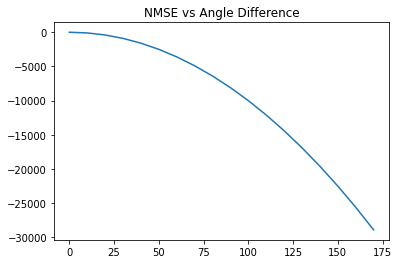

when difference between angles =  0 , score =  1.0
when difference between angles =  10 , score =  0.95004162504212
when difference between angles =  20 , score =  0.802624679775096
when difference between angles =  30 , score =  0.5781009947499921
when difference between angles =  40 , score =  0.33596322973215087
when difference between angles =  50 , score =  0.15171636004248712
when difference between angles =  60 , score =  0.05319398715373169
when difference between angles =  70 , score =  0.014783082688563987
when difference between angles =  80 , score =  0.0033176021603488204
when difference between angles =  90 , score =  0.000606894060057872


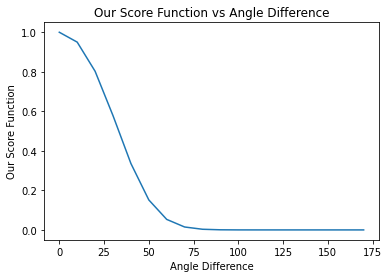

In [5]:
import numpy as np
import matplotlib.pyplot as plt
angle = np.arange(0,180,10)
mse = angle**2
score = 1- np.tanh(0.0005*mse)
plt.plot(angle,-mse)
plt.title("NMSE vs Angle Difference")
plt.show()
plt.plot(angle, score)
plt.title("Our Score Function vs Angle Difference")
plt.xlabel("Angle Difference")
plt.ylabel("Our Score Function")
i=0
for s in score:
  print("when difference between angles = ", i*10, ", score = ", s )
  i+=1
  if i >9:
    break